Problem statement (realistic):
Build a model to forecast daily AQI for Karachi to support air-quality alerts, planning, and health advisories.

Decision this data will support

1. Can we trust this dataset enough to train a forecasting model?

2. Is AQI behavior stable and learnable, or too noisy / broken?

3. Which features are actually predictive vs junk?

AQI EDA hypotheses

- H1: AQI data coverage is consistent over time (no long silent gaps)
- H2: Missing AQI values are NOT random and follow a pattern
- H3: AQI distribution is stable enough to be forecastable
- H4: Weather features correlate with AQI in expected directions
- H5: Extreme AQI spikes are rare and explainable, not data errors
- H6: Data leakage does not exist (no future information)


Data Source:
- AQI: External AQI API
- Weather: External Weather API

Storage:
- MongoDB
- Database: aqi_feature_store
- Collection: raw_aqi_weather_daily

Data Type:
- Raw daily aggregates (NOT user-modified)
- One row per city per day


In [12]:
# Core
import os
import pandas as pd
import numpy as np

# DB
from pymongo import MongoClient
from dotenv import load_dotenv

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Settings
pd.set_option("display.max_columns", None)
sns.set_style("whitegrid")

load_dotenv()


True

In [29]:
MONGO_URI = os.getenv("MONGO_URI")
DB_NAME = "aqi_feature_store"
COLLECTION_NAME = "raw_aqi_weather_daily"

client = MongoClient(MONGO_URI)
collection = client[DB_NAME][COLLECTION_NAME]

df = pd.DataFrame(list(collection.find()))

df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)

print(f"Total raw rows fetched: {df.shape[0]}")
df.head(5)


Total raw rows fetched: 1118


,_id,city,date,aqi_avg,aqi_max,aqi_min,created_at,humidity_avg,precipitation_sum,source_aqi,source_weather,temperature_avg,temperature_max,temperature_min,wind_speed_avg,timestamp
0,6974c5ec9080e275e71ec7dd,Karachi,2023-01-01,152.0,None,None,2026-01-24 13:15:24.371,63,0.0,IQAir,Open-Meteo,19.7,25.0,14.6,16.4,2026-01-24 13:15:24.369
1,6974c5f19080e275e71ec7df,Karachi,2023-01-02,152.0,None,None,2026-01-24 13:15:28.615,47,0.0,IQAir,Open-Meteo,19.8,25.5,14.5,16.1,2026-01-24 13:15:28.612
2,6974c5f49080e275e71ec7e0,Karachi,2023-01-03,152.0,None,None,2026-01-24 13:15:31.963,35,0.0,IQAir,Open-Meteo,19.6,25.4,14.7,22.4,2026-01-24 13:15:31.961
3,6974c5f79080e275e71ec7e1,Karachi,2023-01-04,152.0,None,None,2026-01-24 13:15:34.691,33,0.0,IQAir,Open-Meteo,18.5,24.0,14.1,26.3,2026-01-24 13:15:34.689
4,6974c5f99080e275e71ec7e2,Karachi,2023-01-05,152.0,None,None,2026-01-24 13:15:37.315,29,0.0,IQAir,Open-Meteo,17.6,22.8,12.8,29.3,2026-01-24 13:15:37.313


AQI API returned a constant fallback value (179) for a long period.

In [30]:
unique_aqi = df["aqi_avg"].nunique(dropna=True)
print(f"Unique AQI values (non-null): {unique_aqi}")


Unique AQI values (non-null): 20


Frequency of each AQI value

In [31]:
aqi_value_counts = (
    df["aqi_avg"]
    .value_counts(dropna=True)
    .sort_values(ascending=False)
)

print(aqi_value_counts.head(10))


aqi_avg
90.0     128
129.0    112
122.0    100
127.0     80
179.0     73
76.0      65
83.0      65
99.0      50
78.0      45
115.0     42
Name: count, dtype: int64


Temporal continuity check (this is decisive)



In [32]:
df["aqi_changed"] = df["aqi_avg"] != df["aqi_avg"].shift(1)

# Length of consecutive identical AQI runs
df["run_id"] = df["aqi_changed"].cumsum()

run_lengths = (
    df.groupby("run_id")
      .size()
      .sort_values(ascending=False)
)

print("Top 10 longest flat AQI runs:")
print(run_lengths.head(10))


Top 10 longest flat AQI runs:
run_id
178    112
168    105
175    100
180     80
176     65
169     65
171     50
179     45
181     42
170     40
dtype: int64


Visual sanity check

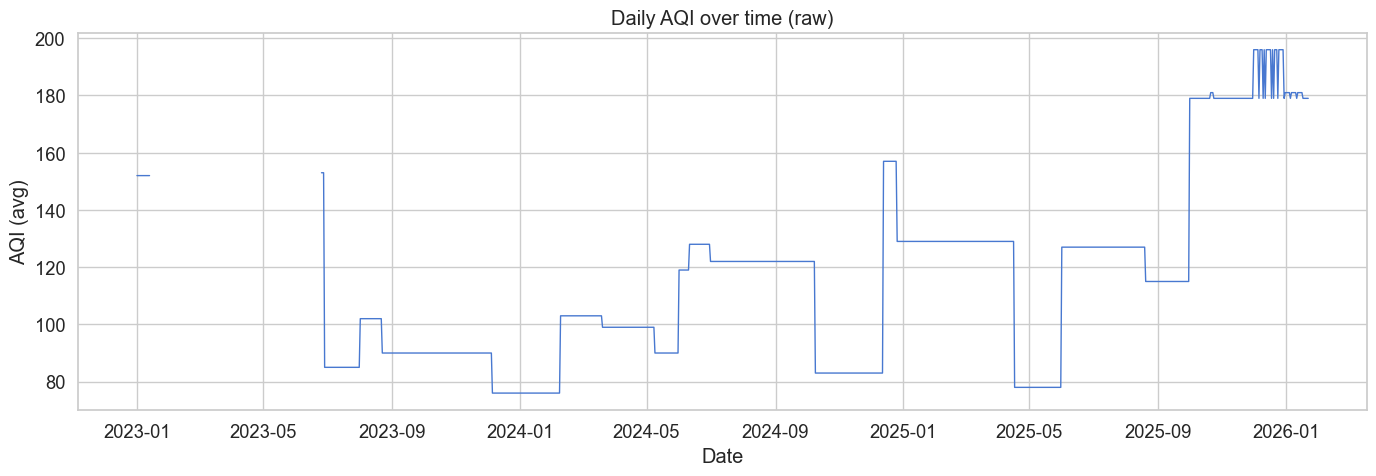

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(df["date"], df["aqi_avg"], linewidth=1)
plt.title("Daily AQI over time (raw)")
plt.xlabel("Date")
plt.ylabel("AQI (avg)")
plt.tight_layout()
plt.show()


In [14]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1118 entries, 0 to 1117
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   _id                1118 non-null   object        
 1   city               1118 non-null   object        
 2   date               1118 non-null   object        
 3   aqi_avg            955 non-null    float64       
 4   aqi_max            0 non-null      object        
 5   aqi_min            0 non-null      object        
 6   created_at         1118 non-null   datetime64[ns]
 7   humidity_avg       1118 non-null   int64         
 8   precipitation_sum  1118 non-null   float64       
 9   source_aqi         1118 non-null   object        
 10  source_weather     1118 non-null   object        
 11  temperature_avg    1118 non-null   float64       
 12  temperature_max    1118 non-null   float64       
 13  temperature_min    1118 non-null   float64       
 14  wind_spe

In [15]:
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["created_at"] = pd.to_datetime(df["created_at"], errors="coerce")


In [16]:
grain_check = (
    df.groupby(["city", "date"])
      .size()
      .reset_index(name="rows_per_city_day")
)

violations = grain_check[grain_check["rows_per_city_day"] > 1]

print("Grain violations:")
violations


Grain violations:


,city,date,rows_per_city_day


Volume, Coverage, Time Completeness

In [17]:
print("Total rows:", len(df))
print("\nRecords per city:")
print(df["city"].value_counts())

print("\nDate range per city:")
coverage = df.groupby("city")["date"].agg(["min", "max", "count"])
coverage


Total rows: 1118

Records per city:
city
Karachi    1118
Name: count, dtype: int64

Date range per city:


,min,max,count
city,,,
Karachi,2023-01-01,2026-01-22,1118


Missing date detection

In [18]:
full_dates = pd.date_range(
    start=df["date"].min(),
    end=df["date"].max(),
    freq="D"
)

missing_dates = set(full_dates.date) - set(df["date"].dt.date)

print("Missing calendar days:", len(missing_dates))


Missing calendar days: 0


Data Quality Checks

In [19]:
null_summary = df.isnull().sum().sort_values(ascending=False)
null_summary


aqi_max              1118
aqi_min              1118
aqi_avg               163
timestamp             163
_id                     0
city                    0
date                    0
created_at              0
humidity_avg            0
precipitation_sum       0
source_aqi              0
source_weather          0
temperature_avg         0
temperature_max         0
temperature_min         0
wind_speed_avg          0
dtype: int64

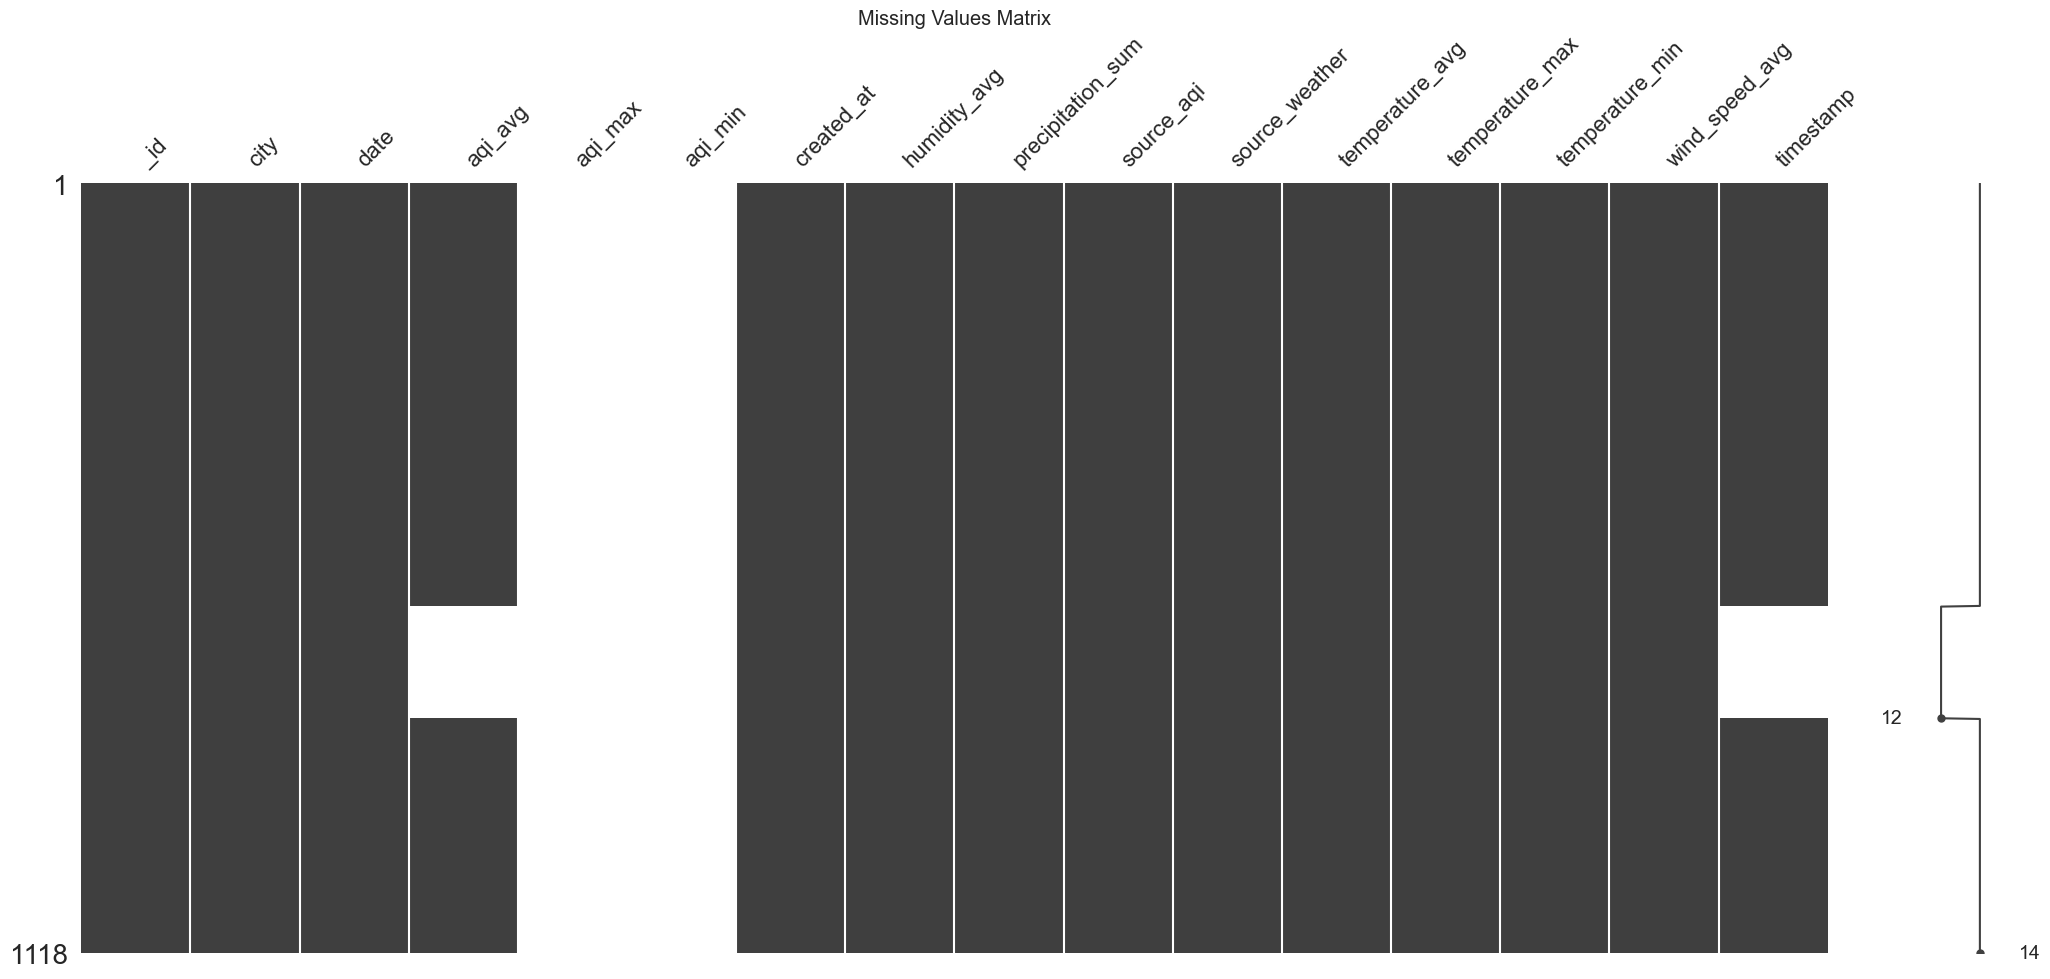

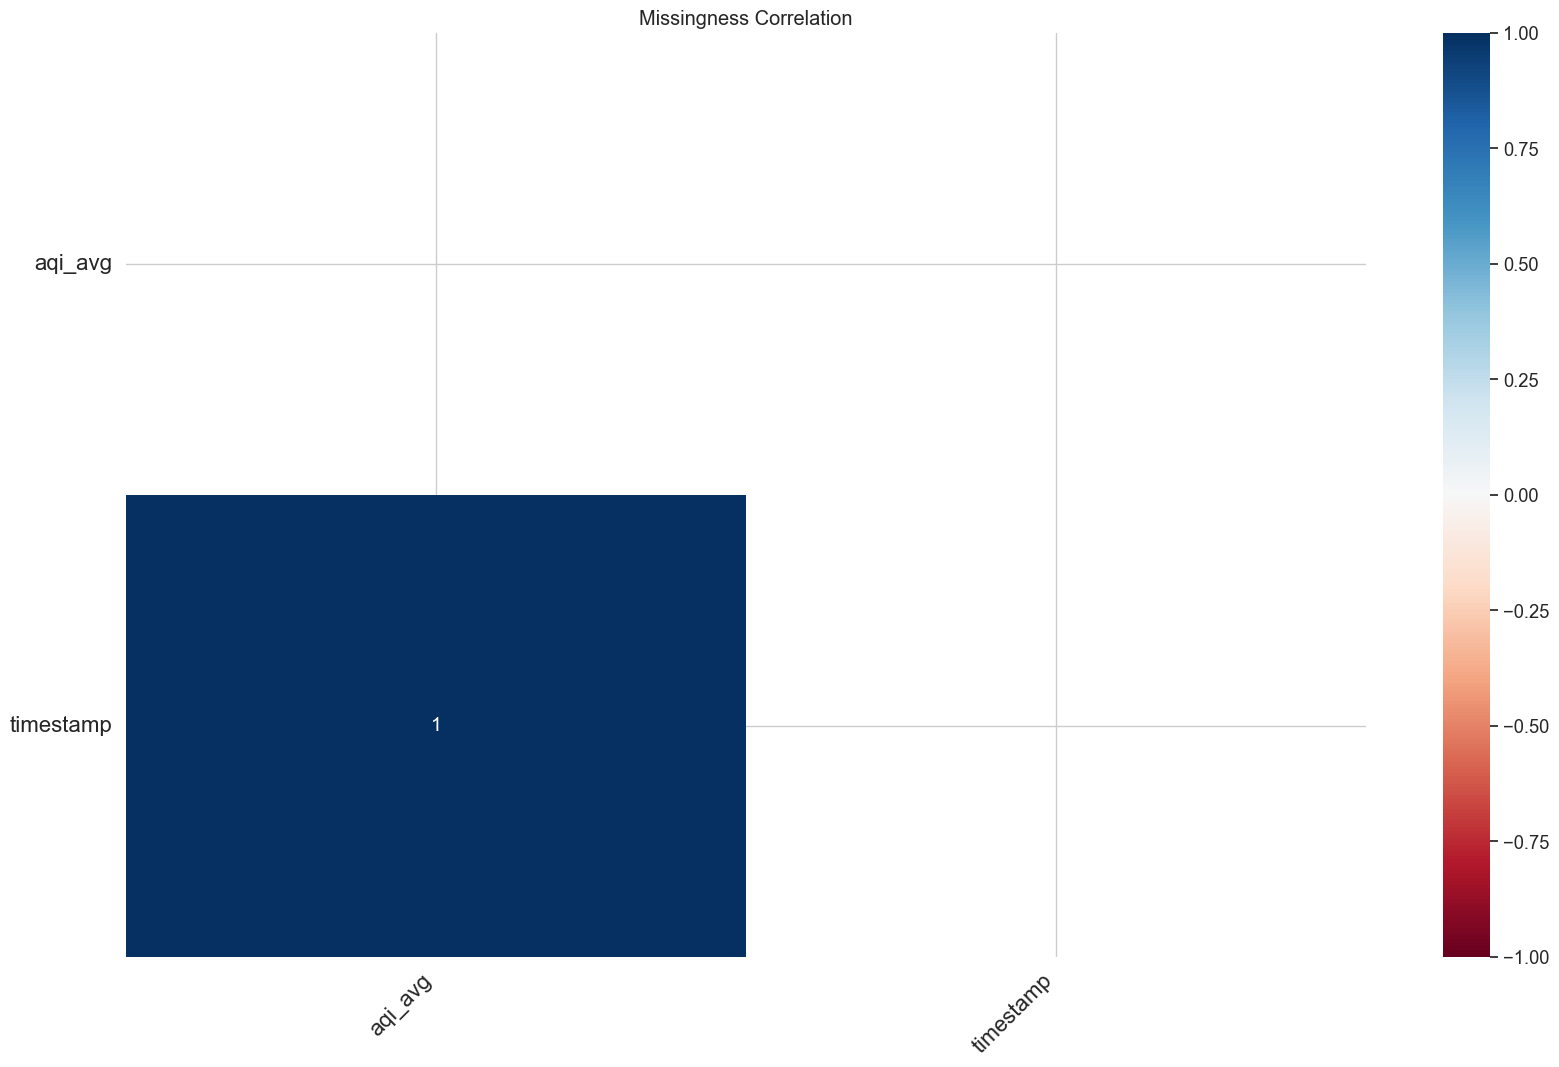

In [20]:
msno.matrix(df)
plt.title("Missing Values Matrix")
plt.show()

msno.heatmap(df)
plt.title("Missingness Correlation")
plt.show()


Is AQI Missing Random?

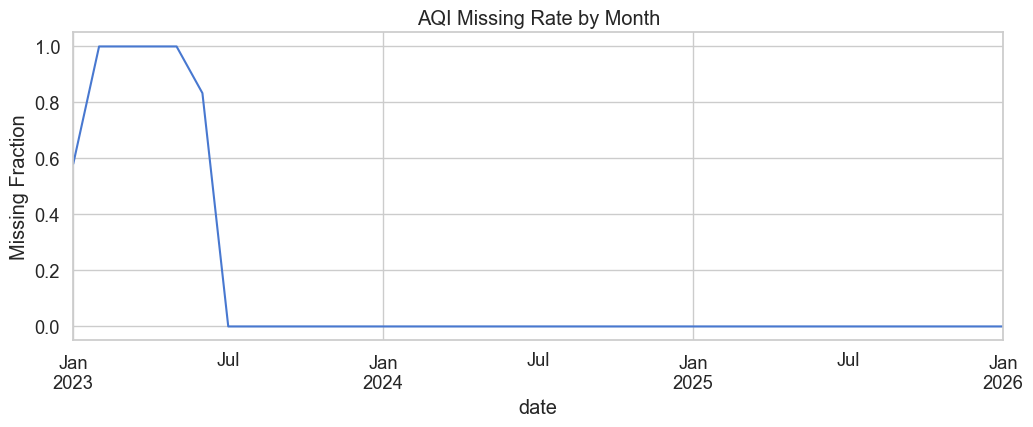

In [21]:
df["aqi_missing"] = df["aqi_avg"].isna().astype(int)

missing_by_month = (
    df.groupby(df["date"].dt.to_period("M"))["aqi_missing"]
      .mean()
)

missing_by_month.plot(
    figsize=(12,4),
    title="AQI Missing Rate by Month"
)
plt.ylabel("Missing Fraction")
plt.show()


In [22]:
df["aqi_avg"].describe()


count    955.000000
mean     115.354974
std       31.967467
min       76.000000
25%       90.000000
50%      115.000000
75%      129.000000
max      196.000000
Name: aqi_avg, dtype: float64

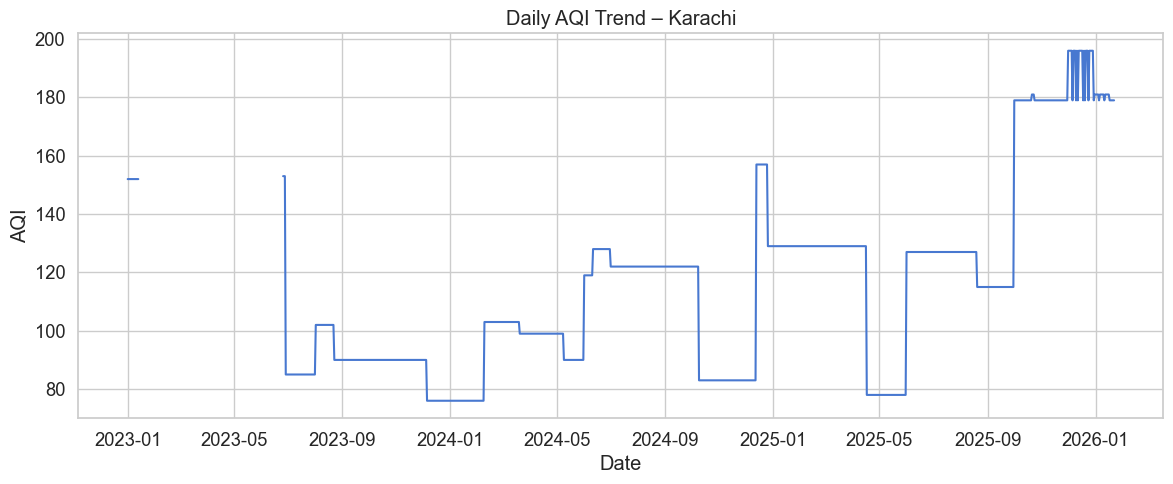

In [23]:
df_sorted = df.sort_values("date")

plt.figure(figsize=(14,5))
plt.plot(df_sorted["date"], df_sorted["aqi_avg"])
plt.title("Daily AQI Trend – Karachi")
plt.xlabel("Date")
plt.ylabel("AQI")
plt.show()


In [24]:
q1 = df["aqi_avg"].quantile(0.25)
q3 = df["aqi_avg"].quantile(0.75)
iqr = q3 - q1

outliers = df[
    (df["aqi_avg"] < q1 - 1.5 * iqr) |
    (df["aqi_avg"] > q3 + 1.5 * iqr)
]

print("Number of potential outliers:", len(outliers))
outliers.sort_values("aqi_avg", ascending=False).head()


Number of potential outliers: 23


,_id,city,date,aqi_avg,aqi_max,aqi_min,created_at,humidity_avg,precipitation_sum,source_aqi,source_weather,temperature_avg,temperature_max,temperature_min,wind_speed_avg,timestamp,aqi_missing
61,6973de8c9080e275e71ebe33,Karachi,2025-12-01,196.0,None,None,2026-01-23 21:01:15.186,45,0.0,IQAir,Open-Meteo,21.3,27.1,16.0,10.6,2026-01-23 21:01:15.184,0
76,6973ded99080e275e71ebe42,Karachi,2025-12-16,196.0,None,None,2026-01-23 21:03:23.273,42,0.0,IQAir,Open-Meteo,22.3,28.1,17.5,14.1,2026-01-23 21:03:23.271,0
88,6973e2969080e275e71ebe5c,Karachi,2025-12-28,196.0,None,None,2026-01-23 21:05:26.536,43,0.0,IQAir,Open-Meteo,20.4,25.6,15.6,8.6,2026-01-23 21:05:26.535,0
87,6973e2959080e275e71ebe5b,Karachi,2025-12-27,196.0,None,None,2026-01-23 21:05:25.099,45,0.0,IQAir,Open-Meteo,20.2,25.5,15.1,10.5,2026-01-23 21:05:25.099,0
86,6973e2939080e275e71ebe5a,Karachi,2025-12-26,196.0,None,None,2026-01-23 21:05:24.004,63,0.0,IQAir,Open-Meteo,19.7,24.5,14.9,8.7,2026-01-23 21:05:24.003,0
